In [1]:
# run in one batch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# scipy imports
import scipy.stats as stats

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# define cleaning functions
def clean_q_data(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    # datetime operations
    q_df['dt'] = pd.to_datetime(q_df['dt_string'])
    q_df['year'] = q_df['dt'].dt.year
    q_df['month'] = q_df['dt'].dt.month
    q_df['day'] = q_df['dt'].dt.day

    # new datetime without time
    q_df['timestamp'] = pd.to_datetime(q_df[['year','month', 'day']], errors='coerce')

    # make series from groupby, this has timestamp as index
    daily_q = q_df.groupby(['timestamp'])['cfs'].mean()

    # make df from series
    daily_q_df = pd.DataFrame(daily_q)
    return(daily_q_df)

def clean_snow_data(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    # unit conversions to metric
    snow_df['swe_start_m'] = snow_df.swe_start_in * 0.0254
    snow_df['airtemp_max_C'] = 5/9*(snow_df.airtemp_max_F - 32)
    snow_df['airtemp_min_C'] = 5/9*(snow_df.airtemp_min_F - 32)
    snow_df['airtemp_mean_C'] = 5/9*(snow_df.airtemp_mean_F - 32)
    snow_df['precip_start_m'] = snow_df.precip_start_in * 0.0254
    snow_df['precip_incr_m'] = snow_df.precip_incr_in * 0.0254
    
    # drop standard unit columns
    snow_df.drop(['swe_start_in'], axis=1, inplace=True)
    snow_df.drop(['airtemp_max_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_min_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_mean_F'], axis=1, inplace=True)
    snow_df.drop(['precip_start_in'], axis=1, inplace=True)
    snow_df.drop(['precip_incr_in'], axis=1, inplace=True)
    
    # datetime operations
    snow_df['dt'] = pd.to_datetime(snow_df['date'])
    snow_df['year'] = snow_df['dt'].dt.year
    
    # remove rows with swe=0
    snow_df.drop(snow_df[snow_df.swe_start_m == 0].index, inplace=True)

    #set snow df index to dt
    snow_df.set_index(snow_df.dt, inplace=True)
    return(snow_df)

def clean_outliers(df):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    # clear min airtemp outliers
    df.drop(df[df.airtemp_min_C > 18].index, inplace=True)
    df.drop(df[df.airtemp_min_C < -40].index, inplace=True)
    # clear max airtemp outliers
    df.drop(df[df.airtemp_max_C > 50].index, inplace=True)
    df.drop(df[df.airtemp_max_C < -45].index, inplace=True)
    return(df)

In [3]:

    
    # annual peak swe
    #peak_swe = snow_df.groupby(snow_df.year)['swe_start_in'].max()

    # annual sum swe
    #sum_swe = snow_df.groupby(snow_df.year)['swe_start_in'].cumsum()

In [4]:
# load q data
q_df = pd.read_csv('q-data/gunnison_delta.csv',sep='\t',header=32) # read csv to dataframe
q_df.columns = ['USGS', 'id', 'dt_string', 'tz', 'cfs', 'junk'] # rename columns

daily_q_df = clean_q_data(q_df)

In [5]:
# load snotel data
stationnames = ['680_park_cone','762_slumgullion','701_porphyry_creek','737_schofield_pass','682_park_reservoir',
                '669_north_lost_trail','1059_cochetopa_pass']
data_lst = []
count = 0
for stationname in stationnames:
    snow_df = pd.read_csv('snotel-data/snotel_{}.csv'.format(stationname),header=58) 
    snow_df.columns = ['date', 'swe_start_in',
       'precip_start_in',
       'airtemp_max_F', 'airtemp_min_F',
       'airtemp_mean_F', 'precip_incr_in']
    # clean snow data
    snow_df = clean_snow_data(snow_df)
    # merge datasets
    merged_df = pd.merge(snow_df, daily_q_df, how='left', left_index=True, right_index=True)

    data_lst.append(merged_df)
    count += 1
print(count)
data_df = pd.concat(data_lst, axis=0, ignore_index = True)

7


In [6]:
# clean outliers
data_clean = clean_outliers(data_df)

In [7]:
# bin by min temp
disc = 0.5 # discretization to bin, in degrees C
bin_idxs = np.arange(data_clean.airtemp_min_C.min(),data_clean.airtemp_min_C.max(),disc,dtype='float')
bins, binvals = pd.cut(data_clean.airtemp_min_C,bin_idxs,right=True,retbins=True)
data_clean['bins'] = bins.values
maxQ_binned = data_clean.groupby(data_clean.bins)['cfs'].max()
#ok here

# data for new regression
SWE_binned = data_clean.groupby(data_clean.bins)['swe_start_m'].mean()
MaxAir_binned = data_clean.groupby(data_clean.bins)['airtemp_max_C'].mean()
MinAir_binned = data_clean.groupby(data_clean.bins)['airtemp_min_C'].mean()
MeanAir_binned = data_clean.groupby(data_clean.bins)['airtemp_mean_C'].mean()
PreStart_binned = data_clean.groupby(data_clean.bins)['precip_start_m'].mean()
PreIncr_binned = data_clean.groupby(data_clean.bins)['precip_incr_m'].mean()

data_binned = pd.concat([SWE_binned,MaxAir_binned,MinAir_binned,MeanAir_binned,PreStart_binned,PreIncr_binned,maxQ_binned], axis=1)
# ok here

# drop nans
data_clean_binned = data_binned.dropna()


In [8]:
#np.shape(data_clean_binned)

In [9]:
data_clean_binned.head(10)


,swe_start_m,airtemp_max_C,airtemp_min_C,airtemp_mean_C,precip_start_m,precip_incr_m,cfs
bins,,,,,,,
"(-36.778, -36.278]",0.403860,-16.666667,-36.666667,-26.666667,0.490220,0.000000,538.937500
"(-36.278, -35.778]",0.289560,-9.444444,-36.111111,-24.722222,0.339090,0.000000,2512.395833
"(-35.778, -35.278]",0.179705,-13.333333,-35.555556,-25.000000,0.236220,0.002540,1328.333333
"(-34.778, -34.278]",0.150223,-14.523810,-34.444444,-24.206349,0.188323,0.001814,1335.729167
"(-34.278, -33.778]",0.281940,-12.037037,-33.888889,-24.259259,0.320887,0.000847,1805.208333
"(-33.778, -33.278]",0.177094,-12.253086,-33.333333,-23.104575,0.202777,0.001411,3256.458333
"(-33.278, -32.778]",0.162560,-8.020833,-32.777778,-20.000000,0.192723,0.000794,1871.875000
"(-32.278, -31.778]",0.185783,-10.264550,-32.222222,-21.375661,0.205135,0.001089,3129.166667
"(-31.778, -31.278]",0.158750,-4.188034,-31.666667,-16.866667,0.189132,0.001172,3534.375000


In [10]:
#feature engineer -squared terms
#model_df = data_clean_binned
# model_df['airmin2'] = model_df.airtemp_min_C**2*-1
# model_df['airmin3'] = model_df.airtemp_min_C**3
# model_df['airmin4'] = model_df.airtemp_min_C**4*-1

In [11]:
# polynomial feature engineering and ridge regression
model_df = data_clean_binned
cols = model_df.columns
# regression
X = model_df[cols[:-1]]
y = model_df[cols[-1]]


In [12]:
# make and fit model
degree = 2
model = make_pipeline(PolynomialFeatures(degree), Ridge());
model.fit(X, y);
y_hat = model.predict(X)
# R2 score
score = model.score(X,y)
print('R2 = {0:.3f}'.format(score))

R2 = 0.936


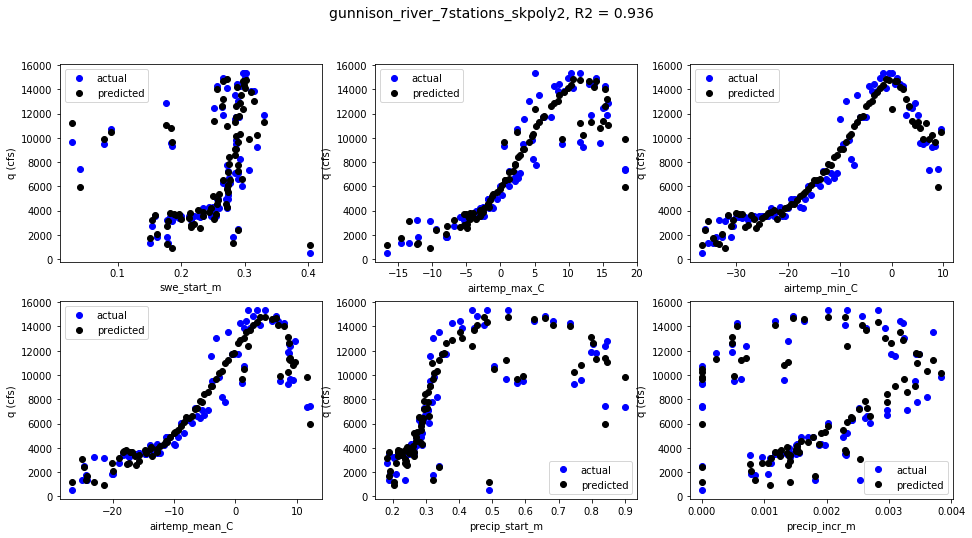

In [13]:
# plot predictions
# plots swe A, B
df = model_df # dataframe to plot from
y # already made
y_hat # already made
figname = 'gunnison_river_7stations_skpoly2'

# plot
fig, ax = plt.subplots(2,3,figsize=(16,8));
arrs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
for x, col in enumerate(cols[:-1]):
    ax[arrs[x]].plot(df[col].values,y,'bo')
    ax[arrs[x]].set_ylabel('q (cfs)');
    ax[arrs[x]].set_xlabel(cols[x])
    ax[arrs[x]].plot(df[col].values,y_hat,'ko')
    ax[arrs[x]].legend(['actual','predicted'])
plt.suptitle('{}, R2 = {}'.format(figname,str(round(score,3))),fontsize=14)

# save fig
fig.set_size_inches(16, 8)
plt.savefig('{}.png'.format(figname),format='png', dpi=300)